<a href="https://colab.research.google.com/github/elichen/rl-snake/blob/main/RL_snake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -q pygame

Final Score: 8


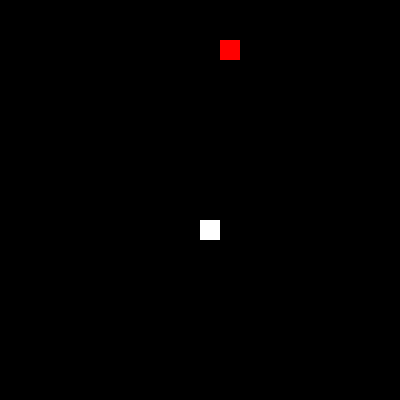

In [73]:
import pygame
import random
import numpy as np
import imageio
import io
from IPython.display import Image, display
from enum import Enum

class Action(Enum):
    LEFT = 0
    STRAIGHT = 1
    RIGHT = 2

class Direction(Enum):
    LEFT = 0
    RIGHT = 1
    UP = 2
    DOWN = 3

class SnakeGame:
    def __init__(self, width, height, grid_size):
        self.width = width
        self.height = height
        self.grid_size = grid_size
        self.grid_width = width // grid_size
        self.grid_height = height // grid_size
        self.snake_speed = 10
        self.black = (0, 0, 0)
        self.white = (255, 255, 255)
        self.red = (255, 0, 0)
        self.window = None
        self.clock = None
        self.reset()

    def reset(self):
        self.snake_x = self.grid_width // 2
        self.snake_y = self.grid_height // 2
        self.snake_dx, self.snake_dy = random.choice([(0, -1), (0, 1), (-1, 0), (1, 0)])
        self.snake_body = [(self.snake_x, self.snake_y)]
        self.food_x = random.randint(0, self.grid_width - 1)
        self.food_y = random.randint(0, self.grid_height - 1)
        self.score = 0
        self.frames = []
        self.game_over = False
        self.snake_direction = random.choice(list(Direction))
        self.food_direction = None
        self.danger_straight = False
        self.danger_right = False
        self.danger_left = False
        self.update_game_state()

    def update_game_state(self):
        snake_x, snake_y = self.snake_body[-1]
        food_x, food_y = self.food_x, self.food_y

        if self.snake_dx == -1:
            self.snake_direction = Direction.LEFT
        elif self.snake_dx == 1:
            self.snake_direction = Direction.RIGHT
        elif self.snake_dy == -1:
            self.snake_direction = Direction.UP
        else:  # self.snake_dy == 1
            self.snake_direction = Direction.DOWN

        if food_x < snake_x:
            self.food_direction = Direction.LEFT
        elif food_x > snake_x:
            self.food_direction = Direction.RIGHT
        elif food_y < snake_y:
            self.food_direction = Direction.UP
        else:  # food_y > snake_y
            self.food_direction = Direction.DOWN

        self.danger_straight = (
            (snake_x + self.snake_dx < 0 or snake_x + self.snake_dx >= self.grid_width) or
            (snake_y + self.snake_dy < 0 or snake_y + self.snake_dy >= self.grid_height) or
            ((snake_x + self.snake_dx, snake_y + self.snake_dy) in self.snake_body)
        )

        self.danger_right = (
            (snake_x + self.snake_dy < 0 or snake_x + self.snake_dy >= self.grid_width) or
            (snake_y - self.snake_dx < 0 or snake_y - self.snake_dx >= self.grid_height) or
            ((snake_x + self.snake_dy, snake_y - self.snake_dx) in self.snake_body)
        )

        self.danger_left = (
            (snake_x - self.snake_dy < 0 or snake_x - self.snake_dy >= self.grid_width) or
            (snake_y + self.snake_dx < 0 or snake_y + self.snake_dx >= self.grid_height) or
            ((snake_x - self.snake_dy, snake_y + self.snake_dx) in self.snake_body)
        )

    def is_food_overlapping_snake(self, food_x, food_y, snake_body):
        return (food_x, food_y) in snake_body

    def play_step(self, action):
        # Move the snake
        if action == Action.LEFT:
            self.snake_dx, self.snake_dy = -self.snake_dy, self.snake_dx
        elif action == Action.RIGHT:
            self.snake_dx, self.snake_dy = self.snake_dy, -self.snake_dx
        elif action == Action.STRAIGHT:
            pass  # Keep the current direction
        self.snake_x += self.snake_dx
        self.snake_y += self.snake_dy
        self.snake_body.append((self.snake_x, self.snake_y))

        # Check for collision with the food
        if self.snake_x == self.food_x and self.snake_y == self.food_y:
            self.score += 1
            while True:
                self.food_x = random.randint(0, self.grid_width - 1)
                self.food_y = random.randint(0, self.grid_height - 1)
                if not self.is_food_overlapping_snake(self.food_x, self.food_y, self.snake_body):
                    break
        else:
            self.snake_body.pop(0)

        # Check for collision with the boundaries
        if self.snake_x < 0 or self.snake_x >= self.grid_width or self.snake_y < 0 or self.snake_y >= self.grid_height:
            self.game_over = True
            return self.game_over, self.score

        # Check for collision with itself
        if len(self.snake_body) > 1 and (self.snake_x, self.snake_y) in self.snake_body[:-1]:
            self.game_over = True
            return self.game_over, self.score

        # Clear the window
        self.window.fill(self.black)

        # Draw the snake
        for body_part in self.snake_body:
            pygame.draw.rect(self.window, self.white, [body_part[0] * self.grid_size, body_part[1] * self.grid_size, self.grid_size, self.grid_size])

        # Draw the food
        pygame.draw.rect(self.window, self.red, [self.food_x * self.grid_size, self.food_y * self.grid_size, self.grid_size, self.grid_size])

        # Update the display
        pygame.display.update()

        # Capture the frame as an image
        frame = pygame.surfarray.array3d(pygame.display.get_surface())
        frame = np.swapaxes(frame, 0, 1)
        self.frames.append(frame)

        self.clock.tick(self.snake_speed)
        self.update_game_state()
        return self.game_over, self.score

    def save_gif(self):
        gif_data = io.BytesIO()
        writer = imageio.get_writer(gif_data, format='GIF', duration=1/self.snake_speed)
        for frame in self.frames:
            writer.append_data(frame)
        writer.close()
        gif_data.seek(0)
        return gif_data

class HeuristicController:
    def __init__(self):
        pass

    def get_action(self, game_state):
        danger_straight, danger_right, danger_left, snake_direction, food_direction = game_state

        if food_direction == snake_direction:
            return Action.STRAIGHT
        elif (
            (food_direction == Direction.LEFT and snake_direction != Direction.RIGHT) or
            (food_direction == Direction.RIGHT and snake_direction != Direction.LEFT) or
            (food_direction == Direction.UP and snake_direction != Direction.DOWN) or
            (food_direction == Direction.DOWN and snake_direction != Direction.UP)
        ):
            if not danger_left:
                return Action.LEFT
            elif not danger_right:
                return Action.RIGHT
            else:
                return Action.STRAIGHT
        else:
            if not danger_right:
                return Action.RIGHT
            elif not danger_left:
                return Action.LEFT
            else:
                return Action.STRAIGHT

# Usage
game = SnakeGame(width=400, height=400, grid_size=20)
controller = HeuristicController()

pygame.init()
game.window = pygame.display.set_mode((game.width, game.height))
pygame.display.set_caption("Snake Game")
game.clock = pygame.time.Clock()

game.reset()
while True:
    game_state = (game.danger_straight, game.danger_right, game.danger_left, game.snake_direction, game.food_direction)
    action = controller.get_action(game_state)
    game_over, score = game.play_step(action)
    if game_over:
        break

print(f"Final Score: {score}")

pygame.quit()

gif_data = game.save_gif()
display(Image(data=gif_data.getvalue(), format='gif'))